# **Challenge Overview – Stock Agent**

Acting as consultants for an investment fund managing a portfolio of 11 stocks, your goal is to build an AI-powered solution that enhances investment decision-making. You may focus on the full portfolio or a specific subset. The aim is to demonstrate how AI can drive financial insights, whether through a trading agent, an analytical dashboard, or another innovative tool.
<br>
<br>
### **Tech & Tools**

It is mandatory to develop the solution in **Google Colab** using **Python**.

Other than that, you are completely free to choose your own:

•	Libraries and packages: Use any tool you need (e.g., Pandas, Scikit-learn, LangChain, etc.)

•	Visualization tools: Python-based tools (Matplotlib, Seaborn), Power BI, Tableau, etc. (if you use external visualization tools, don't forget to include prints in the submission zip folder)

•	AI assistants: Feel free to consult ChatGPT, GitHub Copilot, Gemini, or any other.
<br>
<br>
### **Tech Configuration**

**1** - The second code cell contains the code needed to export the dataset for the 11 assets. All data is saved as individual .csv files in a data/ directory, named according to the asset and frequency (e.g., AMZN_hourly.csv or AMZN_daily.csv).

**2** - The remaining cells include functions suggested by the dev team to help accelerate your solution. Each function comes with a description of its purpose and examples of expected usage. Feel free to use, adapt, extend, or completely rework them to fit your approach.

# Installs & Imports

In [4]:
%pip install protobuf==5.29.0 -q
%pip install yfinance==0.2.59 pandas==2.2.2 matplotlib==3.7.5 seaborn==0.13.2 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

**Data Fetching**

In [5]:
DATA_PATH = 'data/'

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os

# List of symbols to download
symbols = ["AMZN", "AAPL", "GOOGL", "MSFT", "UDMY", "NXE", "SPY",
           "CDR.WA", "EH", "BTC-USD", "ETH-USD"]

# Set date range
end_date = datetime.now()
start_date = end_date - timedelta(days=729)

start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print(f"Downloading hourly data from {start_str} to {end_str} (729 days)")

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Download data for each symbol
for symbol in symbols:
    print(f"\nDownloading hourly data for {symbol}...")

    try:
        # Download hourly data
        data = yf.download(symbol, start=start_str, end=end_str, interval="1h", progress=False)

        if not data.empty:
            # Reset index to make Datetime a column
            data.reset_index(inplace=True)

            # Save to CSV
            safe_name = symbol.replace('-', '_').replace('.', '_')
            filename = f"data/{safe_name}_hourly.csv"
            data.to_csv(filename, index=False)
            print(f"Successfully downloaded {len(data)} rows of hourly data for {symbol}")

            # Display the first 5 rows of data
            print(f"\nFirst 5 rows of {symbol} data:")
            print(data.head())

        else:
            print(f"No hourly data available for {symbol}")

            # Try daily data instead
            print(f"Attempting to download daily data for {symbol} instead...")
            daily_data = yf.download(symbol, start=(start_date - timedelta(days=365)).strftime('%Y-%m-%d'),
                                    end=end_str, interval="1d", progress=False)

            if not daily_data.empty:
                daily_data.reset_index(inplace=True)
                filename = f"data/{symbol.replace('-', '_').replace('.', '_')}_daily.csv"
                daily_data.to_csv(filename, index=False)
                print(f"Successfully downloaded {len(daily_data)} rows of daily data for {symbol}")

                # Display the first 5 rows of daily data
                print(f"\nFirst 5 rows of {symbol} daily data:")
                print(daily_data.head())
            else:
                print(f"Failed to download any data for {symbol}")

    except Exception as e:
        print(f"Error downloading data for {symbol}: {str(e)}")

# Create summary of downloaded files
file_info = []
for symbol in symbols:
    safe_name = symbol.replace('-', '_').replace('.', '_')
    hourly_path = f"data/{safe_name}_hourly.csv"
    daily_path = f"data/{safe_name}_daily.csv"

    if os.path.exists(hourly_path):
        df = pd.read_csv(hourly_path)
        file_info.append({
            'Symbol': symbol,
            'Filename': hourly_path,
            'Rows': len(df),
            'Start Date': df['Datetime'].iloc[0],
            'End Date': df['Datetime'].iloc[-1],
            'Frequency': 'Hourly'
        })
    elif os.path.exists(daily_path):
        df = pd.read_csv(daily_path)
        file_info.append({
            'Symbol': symbol,
            'Filename': daily_path,
            'Rows': len(df),
            'Start Date': df['Date'].iloc[0],
            'End Date': df['Date'].iloc[-1],
            'Frequency': 'Daily'
        })
    else:
        file_info.append({
            'Symbol': symbol,
            'Filename': 'N/A',
            'Rows': 0,
            'Start Date': 'N/A',
            'End Date': 'N/A',
            'Frequency': 'N/A'
        })

# Display file summary
file_summary = pd.DataFrame(file_info)
print("\nFile Summary:")
print(file_summary)

print("\nData collection complete!")


YF.download() has changed argument auto_adjust default to True
Successfully downloaded 3480 rows of hourly data for AMZN

First 5 rows of AMZN data:
Price                   Datetime       Close        High         Low  \
Ticker                                  AMZN        AMZN        AMZN   
0      2023-05-31 13:30:00+00:00  120.309998  122.040001  120.065002   
1      2023-05-31 14:30:00+00:00  119.474998  120.720001  119.430000   
2      2023-05-31 15:30:00+00:00  119.180099  119.760002  119.169998   
3      2023-05-31 16:30:00+00:00  120.040001  120.045303  119.180000   
4      2023-05-31 17:30:00+00:00  120.260002  120.500000  119.864998   

Price         Open    Volume  
Ticker        AMZN      AMZN  
0       121.474998  14076654  
1       120.309998   7724152  
2       119.474998   5348107  
3       119.195000   4126924  
4       120.050003   5393898  

Successfully downloaded 3480 rows of hourly data for AAPL

First 5 rows of AAPL data:
Price                   Datetime       Cl

**Possible Implementation Ideas**

In [17]:
# Perform basic data exploration
def explore_data(data, symbol_name=None):
    """Generate basic statistics and visualizations of the market data."""
    # Example steps:
    # - Print summary statistics
    # - Plot closing prices over time
    # - Identify any outliers or anomalies

    datetime_col = 'Datetime'
    # Convert datetime column to datetime type if it's not already
    
    # Create subplots - 2 rows, 1 column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Closing Price over time
    ax1.plot(data[datetime_col], data['Close'], color='blue', linewidth=1)
    ax1.set_title(f'{symbol_name if symbol_name else "Stock"} - Closing Price Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price ($)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Volume over time
    ax2.plot(data[datetime_col], data['Volume'], color='green', linewidth=1)
    ax2.set_title(f'{symbol_name if symbol_name else "Stock"} - Volume Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Format y-axis for volume to show in millions/billions
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.1f}K'))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print(f"\nKey Insights:")
    print(f"Highest closing price: ${data['Close'].max():.2f}")
    print(f"Lowest closing price: ${data['Close'].min():.2f}")
    print(f"Average closing price: ${data['Close'].mean():.2f}")
    print(f"Highest volume: {data['Volume'].max():,}")
    print(f"Average volume: {data['Volume'].mean():,.0f}")
    

    return None

TypeError: 'value' must be an instance of str or bytes, not a float

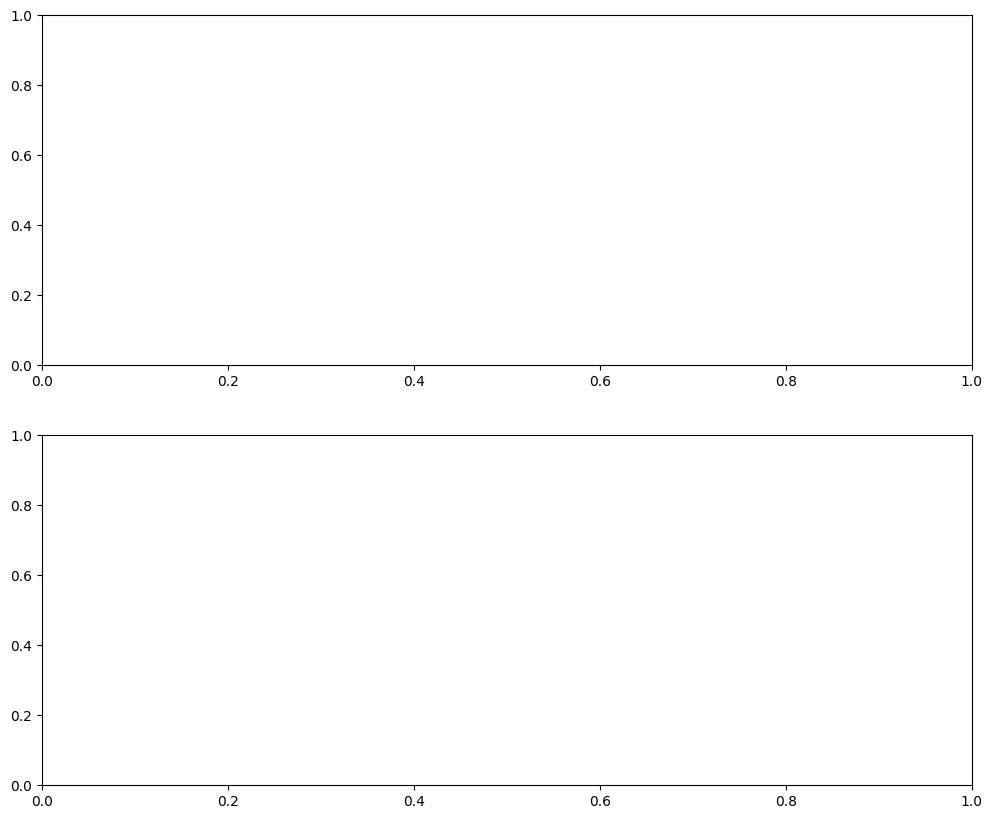

In [ ]:
amzn_data = pd.read_csv(DATA_PATH + 'AMZN_hourly.csv', skiprows=[1])
explore_data(amzn_data, symbol_name='Amazon (AMZN)')

In [ ]:
# Visualize technical indicators
def visualize_indicators(data):
    """Add and plot technical indicators like SMA, EMA, RSI, etc."""
    # Example steps:
    # - Compute simple and exponential moving averages
    # - Plot with the original closing price
    # - Highlight crossover points

    return None


In [ ]:
# Perform ML Analysis to identify trends and make predictions
def analyze_market_trends(market_data):
    """Apply ML techniques to analyze stock/crypto trends."""
    # Example steps:
    # - Normalize data for better trend detection
    # - Apply time series models (ARIMA, LSTMs, etc.)
    # - Identify market linearity and anomalies
    # - Predict future price movements

    return {}


In [ ]:
# Generate trading signals based on strategy
def generate_trading_signals(data):
    """Define and apply rules to generate buy/sell signals."""
    # Example strategy ideas:
    # - SMA crossover
    # - RSI-based entry/exit
    # - Price breakout detection

    return []


In [ ]:
# Simulate portfolio performance
def simulate_portfolio(data, signals):
    """Backtest the strategy using historical data and generated signals."""
    # Example steps:
    # - Initialize a virtual portfolio
    # - Buy/sell based on signals
    # - Track cumulative returns and drawdowns

    return {}


In [ ]:
# Evaluate strategy performance
def evaluate_strategy(results):
    """Evaluate strategy using key metrics."""
    # Example metrics:
    # - Cumulative returns
    # - Sharpe ratio
    # - Maximum drawdown

    return {}


In [ ]:
# Wrap-up and discussion
def reflect_on_findings():
    """Summarize insights and propose next steps."""
    # Example:
    # - What worked? What didn’t?
    # - How would you improve the strategy?
    # - What other data might help?

    return None
